In [1]:
!pip install pyparsing==2.4.6

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
from src.core import Term, Atom
from src.ilp import Language_Frame, Program_Template, Rule_Template
from src.dilp import DILP
import tensorflow as tf
import numpy as np
from src.utils import process_file, process_dir, create_table, output_rules, test_rule, train, test
from src.generate_template import create_templates
import duckdb
tf.random.set_seed(1000)


2024-05-16 13:54:21.792840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 13:54:22.951048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
con = duckdb.connect(':memory:')
# enable automatic query parallelization
con.execute("PRAGMA threads=2")
# enable caching of parquet metadata
con.execute("PRAGMA enable_object_cache")

## Rule template
 Rule_Template(v: int, allow_intensional: bool): 
v is number of existentially qualified variables(X,Y,Z...) in the clause

Program_Template(p_a: list, rules: dict, T: int):
 p_a {list} -- set of auxiliary predicates; these are the additional invented predicates used to help define the target predicate
 
 
 rules {tuple} -- Map of intensional predicate to a pair if rule templates 
 T {int} -- Max number of steps of forward chaining inference

## a, b, c learning

In [5]:
%%time 
input_dir = '../examples/a-b-c/'
input_table = create_table(con, input_dir)
print(f'ratio of positives %f' % (100*input_table['Target'].sum()/len(input_table)))

target, p_e, constants, B, P, N = process_dir(input_dir)

# arity 1
term_x_0 = Term(True, 'X_0')
p_a, rules = create_templates(p_e, target, term_x_0)

# target_rule = (Rule_Template(v=0, allow_intensional=False), None)
# rules = {target: target_rule} 

language_frame = Language_Frame(target, p_e, constants)

ratio of positives 8.000000
142
end of facts processing
8
end of positive examples processing
83
end negative examples processing
data is in order
CPU times: user 89.9 ms, sys: 0 ns, total: 89.9 ms
Wall time: 90.2 ms


Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 0.23161204159259796
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(22) Expected: 0 0.127
Target(37) Expected: 0 0.514
Target(56) Expected: 0 0.014
Target(6) Expected: 0 0.292
Target(74) Expected: 0 0.014
Target(25) Expected: 0 0.514
Target(35) Expected: 0 0.294
Target(77) Expected: 0 0.014
Target(26) Expected: 0 0.081
Target(7) Expected: 0 0.014
Target(72) Expected: 0 0.127
Target(51) Expected: 0 0.294
Target(8) Expected: 0 0.127
Target(34) Expected: 1 1.000
Target(89) Expected: 0 0.081
Target(31) Expected: 0 0.014
Target(66) Expected: 0 0.292
Target(73) Expected: 0 0.292
Target(65) Expected: 0 0.014
Target(41) Expected: 0 0.081
Target(86)

'select A and B as pred1,\n pred1 and C as Target,\n'

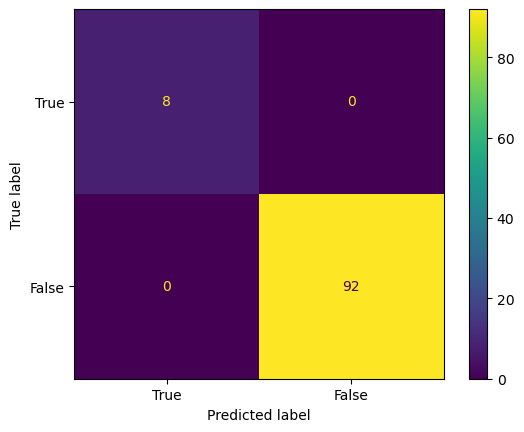

In [6]:
T=2
program_template = Program_Template(p_a, rules, T=T)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp, input_table, con)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 0.5276482701301575
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(22) Expected: 0 0.152
Target(37) Expected: 0 0.859
Target(56) Expected: 0 0.039
Target(6) Expected: 0 0.396
Target(74) Expected: 0 0.039
Target(25) Expected: 0 0.859
Target(35) Expected: 0 0.548
Target(77) Expected: 0 0.039
Target(26) Expected: 0 0.179
Target(7) Expected: 0 0.039
Target(72) Expected: 0 0.152
Target(51) Expected: 0 0.548
Target(8) Expected: 0 0.152
Target(34) Expected: 1 1.000
Target(89) Expected: 0 0.179
Target(31) Expected: 0 0.039
Target(66) Expected: 0 0.396
Target(73) Expected: 0 0.396
Target(65) Expected: 0 0.039
Target(41) Expected: 0 0.179
Target(86) 

'select A and B as pred1,\n pred1 and C as Target,\n'

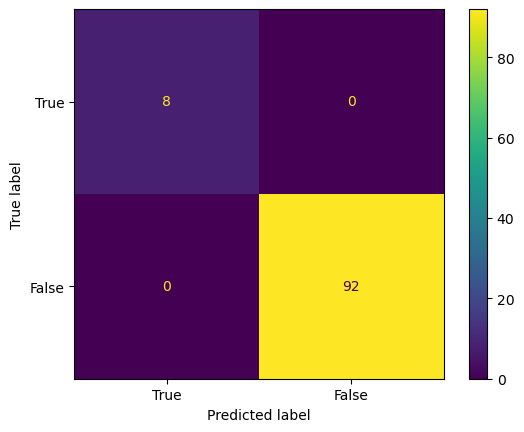

In [7]:
T=3
program_template = Program_Template(p_a, rules, T=T)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp, input_table, con)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 1.4103302955627441
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(22) Expected: 0 0.103
Target(37) Expected: 0 0.983
Target(56) Expected: 0 0.036
Target(6) Expected: 0 0.934
Target(74) Expected: 0 0.036
Target(25) Expected: 0 0.983
Target(35) Expected: 0 0.872
Target(77) Expected: 0 0.036
Target(26) Expected: 0 0.748
Target(7) Expected: 0 0.036
Target(72) Expected: 0 0.103
Target(51) Expected: 0 0.872
Target(8) Expected: 0 0.103
Target(34) Expected: 1 1.000
Target(89) Expected: 0 0.748
Target(31) Expected: 0 0.036
Target(66) Expected: 0 0.934
Target(73) Expected: 0 0.934
Target(65) Expected: 0 0.036
Target(41) Expected: 0 0.748
Target(86) 

'select C and B as pred1,\n pred1 and A as Target,\n'

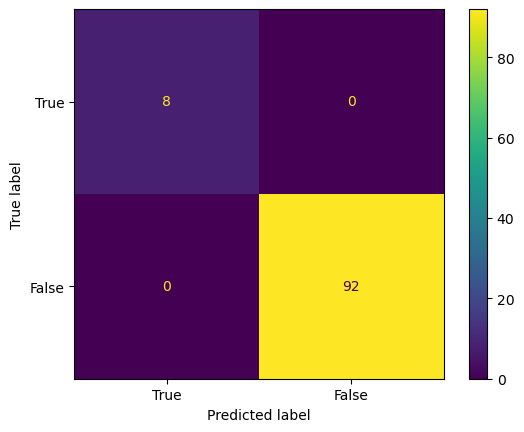

In [8]:
T=5
program_template = Program_Template(p_a, rules, T=T)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp, input_table, con)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 4.21598482131958
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(22) Expected: 0 0.630
Target(37) Expected: 0 1.000
Target(56) Expected: 0 0.433
Target(6) Expected: 0 0.995
Target(74) Expected: 0 0.433
Target(25) Expected: 0 1.000
Target(35) Expected: 0 0.991
Target(77) Expected: 0 0.433
Target(26) Expected: 0 0.763
Target(7) Expected: 0 0.433
Target(72) Expected: 0 0.630
Target(51) Expected: 0 0.991
Target(8) Expected: 0 0.630
Target(34) Expected: 1 1.000
Target(89) Expected: 0 0.763
Target(31) Expected: 0 0.433
Target(66) Expected: 0 0.995
Target(73) Expected: 0 0.995
Target(65) Expected: 0 0.433
Target(41) Expected: 0 0.763
Target(86) Ex

'select A and B as pred1,\n pred1 and C as Target,\n'

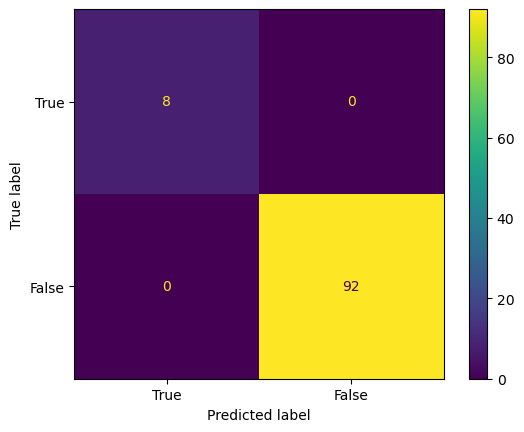

In [9]:
T=10
program_template = Program_Template(p_a, rules, T=T)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp, input_table, con)